In [7]:
# THis script loads images cropped by CropCrossings notebook.  It then counts foci in every iamge

from __future__ import division, print_function
from ipywidgets import interact, interactive, fixed, interact_manual    
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy as sp
from scipy import ndimage
from IPython.core.debugger import set_trace
import cv2
import sys
from pprint import pprint
from random import randint
from nuclei.foci import *
import nuclei.girder as g
import nuclei.girder.time_lapse_data as reader

plt.rcParams['image.cmap'] = 'gist_earth'
matplotlib.rcParams['figure.figsize'] = (11.0, 11.0)




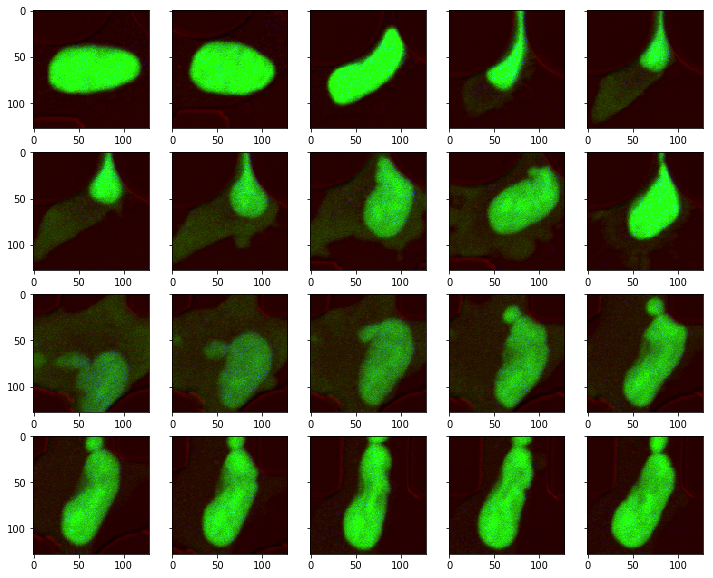

In [13]:
# read images from a girder lightbox

#item_id = '5ad8a5111fbb9005ff71ce11'
#item_id = '5ad8a57f1fbb9005ff71ce3a'
#item_id = '5ad8a6921fbb9005ff71ce63'
#item_id = '5ad8a2e81fbb9005ff71cde8'
#item_id = '5ad8aa121fbb9005ff71ce94'
#item_id = '5ad8aa4f1fbb9005ff71cebd'

#item_id = '5ad968af1fbb9005ff724b9b'
item_id = '5ada5e3a1fbb9052b6c0d19a'
images = g.read_item_images(item_id)






fig, ax = plt.subplots(4,5, sharey=True, figsize=(12,10))
# We need this coplexity because the arrays might not have 10 images.
# It still does not work, but it does not matter. These are for debugging.
count = 0
for x in range(4):
    for y in range(5):
        if count < len(images):
            ax[x][y].imshow(images[count], aspect="auto")
        count += 1




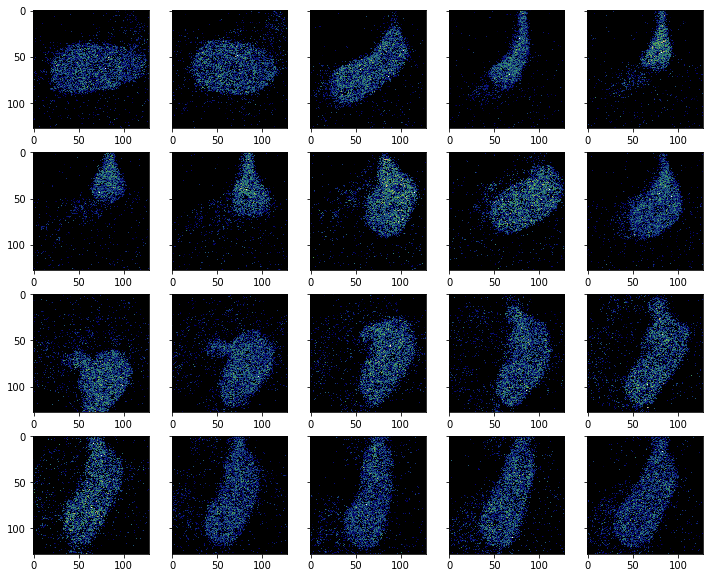

In [14]:
# extract just the opencv blue (normal red) channel (seems that most foci are in this channel)
# Note that matplotlib uses a color map when rendering single channel images.
foci_images = [im[...,2] for im in images]


fig, ax = plt.subplots(4,5, sharey=True, figsize=(12,10))
# We need this coplexity because the arrays might not have 10 images.
# It still does not work, but it does not matter. These are for debugging.
count = 0
for x in range(4):
    for y in range(5):
        if count < len(foci_images):
            ax[x][y].imshow(foci_images[count], aspect="auto")
        count += 1

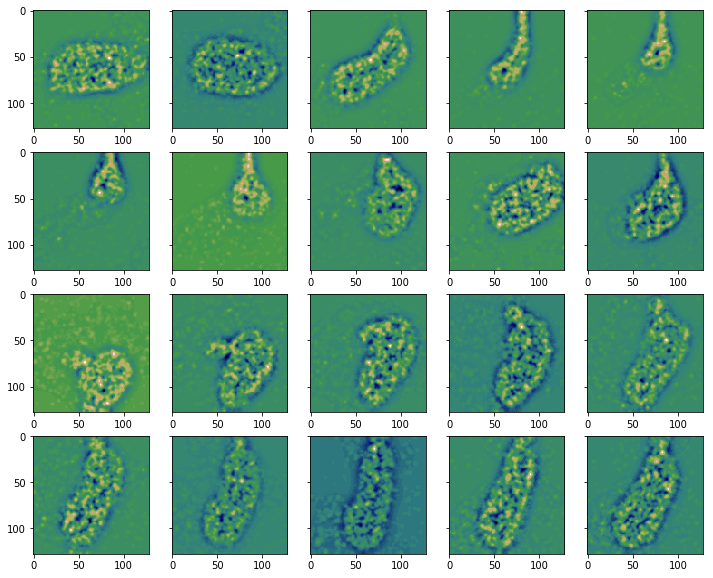

In [15]:
# Apply a center suround / badpass filter 

def bandpass(img):
    center_std = 1.5
    # change the surround standard deviation to get rid of spots
    surround_std = 6

    # kernel size has to be an integer and odd. 
    # If it is too small, the tails of gaussians are truncated.
    # if it is too big, the gaussian blur takes a long time to run.
    k = int(center_std*2)*2+1
    center = cv2.GaussianBlur(img,(k,k),center_std)
    k = int(surround_std*2)*2+1
    surround = cv2.GaussianBlur(img,(k,k),surround_std)

    # Assume Gaussian blur preserves scale (kernel sums to 1)
    # subtrace surround from center to get center surround filter (band pass)
    out = center.astype(np.float)-surround.astype(np.float)    
    return out
        
filtered_images = [bandpass(im) for im in foci_images]



fig, ax = plt.subplots(4,5, sharey=True, figsize=(12,10))
# We need this coplexity because the arrays might not have 10 images.
# It still does not work, but it does not matter. These are for debugging.
count = 0
for x in range(4):
    for y in range(5):
        if count < len(filtered_images):
            ax[x][y].imshow(filtered_images[count], aspect="auto")
        count += 1
        

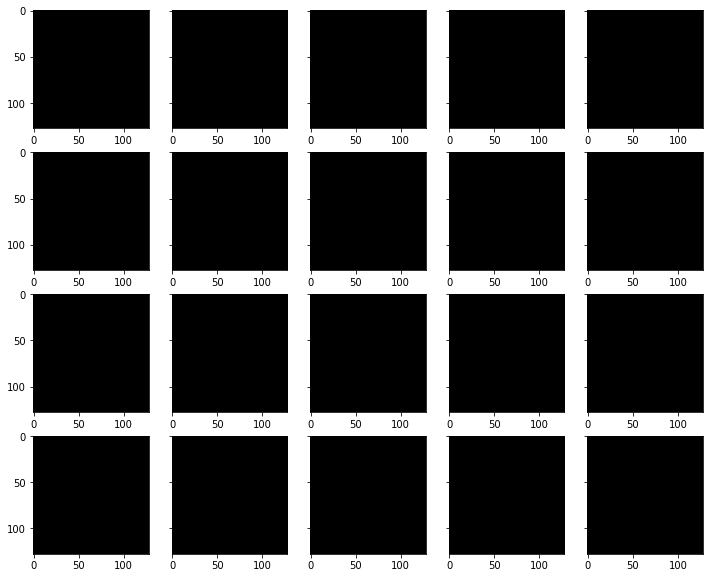

In [16]:
# Threshold the images

def thresh(img):
    # change this to isolate the spots after filtering
    threshold = 50.0 # 140.0
    #out = img.clip(0,255).astype(np.uint8)
    ret,out = cv2.threshold(img,threshold,255,cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    out = cv2.morphologyEx(out, cv2.MORPH_OPEN, kernel)
    return out


thresholded_images = [thresh(im) for im in filtered_images]

fig, ax = plt.subplots(4,5, sharey=True, figsize=(12,10))
# We need this coplexity because the arrays might not have 10 images.
# It still does not work, but it does not matter. These are for debugging.
count = 0
for x in range(4):
    for y in range(5):
        if count < len(thresholded_images):
            ax[x][y].imshow(thresholded_images[count], aspect="auto")
        count += 1
    

In [17]:
# count th
#run center surround

def getFociCount(img):
    """
    # change the center standard deviation to get rid of speckle noise but not spots
    center_std = 1.0
    # change the surround standard deviation to get rid of spots
    surround_std = 15

    # change this to isolate the spots after filtering
    threshold = 128.0

    # kernel size has to be an integer and odd. 
    # If it is too small, the tails of gaussians are truncated.
    # if it is too big, the gaussian blur takes a long time to run.
    k = int(center_std*2)*2+1
    center = cv2.GaussianBlur(img,(k,k),center_std)
    k = int(surround_std*2)*2+1
    surround = cv2.GaussianBlur(img,(k,k),surround_std)

    # Assume Gaussian blur preserves scale (kernel sums to 1)
    # subtrace surround from center to get center surround filter (band pass)
    out = center.astype(np.float)-surround.astype(np.float)

    cs = out - np.min(out)
    cs = cs / np.max(cs)


    # Threshold/clip low values.  We are only interested in white spots.
    #out = out.clip(threshold)
    #print(np.min(out))
    # scale the output image to have range 0->1 for display
    #out = out - np.min(out)
    #print(np.max(out))
    #out = out / np.max(out)
    #print(img.shape)
    #print(surround.shape)
    """
    #out = img.clip(0,255).astype(np.uint8)
    #ret,out = cv2.threshold(out,threshold,255,cv2.THRESH_BINARY)
    
    # find peaks
    #num_features = sp.ndimage.measurements.label(mask, structure=None, output=None)

    
    #out = out[:,:,0:1]
    img = np.array(img, dtype=np.uint8)
    im2, contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    num_features = len(contours)
    
    return(num_features)


counts = [getFociCount(im) for im in thresholded_images]
print(counts)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
